# LangGraph HITL (Human in the Loop)
## 뉴스 검색 keyword 가드레일

- **동적 인터럽트 (Dynamic Interrupts)**: 특정 노드 내에서 코드 실행 중 조건에 따라 `interrupt()` 함수를 호출하여 그래프를 일시 중지
- **정적 인터럽트 (Static Interrupts)**: 그래프를 컴파일할 때 `interrupt_before` 또는 `interrupt_after` 인자를 사용하여 특정 노드의 실행 전후에 항상 일시 중지되도록 설정

In [1]:
import uuid
from typing import Annotated, Optional, TypedDict

from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph.message import add_messages

from dotenv import load_dotenv
from langchain_teddynote.tools import GoogleNews
from langchain_teddynote.graphs import visualize_graph

RISKY_KEYWORDS = [
    "자살", "자해", "폭력", "살인", "강간",
    "19금", "성인", "포르노", "야동", "음란"
]

## 도구 및 상태 구성

In [2]:
load_dotenv()

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

checkpointer = InMemorySaver()


In [3]:
google_news= GoogleNews()

@tool
def news_search(query: str) -> str:
    """뉴스 검색 도구를 호출해 결과를 반환한다."""
    print(f"[Tool] news_search 호출: {query}")
    results = google_news.search_by_keyword(query, k=5)
    text = "\n".join(
        f"- {r.get('content','(내용없음)')} | {r.get('url','')}" for r in results
    ) or "검색 결과 없음"
    return text


def contains_risky_term(text: str) -> bool:
    """텍스트에 위험/민감 키워드가 포함됐는지 검사한다."""
    text = str(text or "").strip().lower()
    return any(k in text for k in (kw.lower() for kw in RISKY_KEYWORDS))

@tool
def keyword_guardrail(query: str) -> str:
    """
    질의에 위험/민감 키워드가 포함됐는지 검사하고, 포함 시 사람에게 승인을 구하기 위해 실행을 중단한다.
    - 위험어 포함: interrupt(...)로 일시 중단 → 재개 후 'APPROVED' 또는 'DENIED' 반환
    - 미포함: 'SAFE' 반환
    """
    print(f"[Tool] keyword_guardrail 호출: {query}")

    if contains_risky_term(query):
        print(f"[Tool] interrupt 발생 — 위험 질의: {query}")
        resume_payload = interrupt({"query": query})
        print(f"[Tool] resume_payload 수신: {resume_payload}")
        user_decision = str(resume_payload.get("data", "")).strip().lower()
        if user_decision in {"예", "yes"}:
            return "APPROVED"
        return "DENIED"
    return "SAFE"

tools = [keyword_guardrail, news_search]
llm_with_tools = llm.bind_tools(tools)

## 상태 정의

In [4]:
class AgentState(TypedDict, total=False):
    messages: Annotated[list, add_messages]
    result: Optional[str]


## 그래프 노드 정의

In [5]:
system_prompt = (
    "사용자의 모든 입력에 대해 반드시 keyword_guardrail 도구를 호출하여 "
    "안전성을 판별하세요. 응답이 SAFE인 경우에는 news_search 도구를 사용하여 "
    "뉴스 기사를 검색하세요."
)

def agent_node(state: AgentState) -> AgentState:
    """LLM에 상태의 메시지들을 전달하고 응답을 받아 상태에 추가 """
    messages = [SystemMessage(content=system_prompt)] + state.get("messages", [])
    ai = llm_with_tools.invoke(messages)
    return {"messages": [ai]}

def extract_guardrail_result(state: AgentState) -> AgentState:
    """상태의 메시지들에서 keyword_guardrail 도구의 결과를 추출하여 상태에 추가"""
    for msg in reversed(state["messages"]):
        if getattr(msg, "name", None) == "keyword_guardrail":
            return {"result": msg.content}
    return {}

## 그래프 구성 및 컴파일

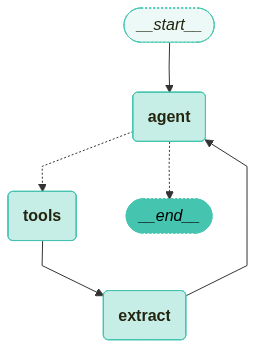

In [6]:
graph = StateGraph(AgentState)
graph.add_node("agent", agent_node)
graph.add_node("tools", ToolNode([keyword_guardrail]))
graph.add_node("extract", extract_guardrail_result)

graph.add_edge(START, "agent")
graph.add_conditional_edges("agent", tools_condition)
graph.add_edge("tools", "extract")
graph.add_edge("extract", "agent")
graph.add_edge("agent", END)
graph.add_edge("extract", END)

app = graph.compile(checkpointer=InMemorySaver())

visualize_graph(app)

## 실행 로직

In [7]:
cfg = {"configurable": {"thread_id": str(uuid.uuid4())}}

try:
    app.invoke({"messages": [HumanMessage(content="최신 자살 뉴스를 검색해줘")]}, config=cfg)
except BaseException:
    print("[중단됨 → 사용자 응답 필요]")


[Tool] keyword_guardrail 호출: 최신 자살 뉴스
[Tool] interrupt 발생 — 위험 질의: 최신 자살 뉴스


In [8]:

result = app.invoke(Command(resume={"data": "아니오"}), config=cfg)
print("최종 결과:", result.get("result"))

[Tool] keyword_guardrail 호출: 최신 자살 뉴스
[Tool] interrupt 발생 — 위험 질의: 최신 자살 뉴스
[Tool] resume_payload 수신: {'data': '아니오'}
최종 결과: DENIED


In [9]:
cfg = {"configurable": {"thread_id": str(uuid.uuid4())}}

try:
    app.invoke({"messages": [HumanMessage(content="최근 자살 뉴스를 검색 해줘")]}, config=cfg)
except BaseException:
    print("[중단됨 → 사용자 응답 필요]")
    


[Tool] keyword_guardrail 호출: 최근 자살 뉴스
[Tool] interrupt 발생 — 위험 질의: 최근 자살 뉴스


In [10]:
result = app.invoke(Command(resume={"data": "예"}), config=cfg)
print("최종 결과:", result.get("result"))

[Tool] keyword_guardrail 호출: 최근 자살 뉴스
[Tool] interrupt 발생 — 위험 질의: 최근 자살 뉴스
[Tool] resume_payload 수신: {'data': '예'}
최종 결과: APPROVED


-----
** End of Documents **